# Neural Collaborative Based Filtering

- using neural network to learn the user-item interaction

This piece is a TensorFlow implementation of Neural Collaborative Filtering (NCF) from the paper [He et al. (2017)](https://arxiv.org/pdf/1708.05031.pdf).

## Summary

NCF uses neural networks to model the interactions between users and items. NCF replaces the inner product (used in ordinary MF methods) with a neural architecture that can learn an arbitrary function from data. This allows NCF to express and generalize matrix factorization under its framework. Essentially, it uses a neural network to learn the user-item interaction function, and uses the learned function to predict the corresponding rating. A multi-layer perceptron is used to learn the user-item interaction function. 


In [20]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# tensorflow libraries load
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

## Model 1: Ratings Only

The steps are as follows:

1. Read in Original Data
2. Remove some ratings to create the test set
3. With remaining ratings, create training set
4. Preprocess the data (melt the data, create user and item indices, normalize the ratings)
5. Create neural network model (NCF)
6. Train the model
7. Hyperparameter tuning
8. Evaluate the model on the test set
9. Gather all ratings prediction metrics (MAE, MSE, RMSE)

In [21]:
# load data
amz_data = pd.read_csv(r'c:\Users\e1002902\Downloads\amz_data.csv')
display(amz_data.head())

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))

# Creating a Subset of the Data =====================================================
# Only keep users who have rated more than 20 products
user_counts = amz_data['reviewerID'].value_counts()
amz_data = amz_data[amz_data['reviewerID'].isin(user_counts[user_counts >= 20].index)]
print("\n\nSubset of the Data")
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))
print('Number of Rows: ', amz_data.shape[0])

# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())

,reviewerID,reviewerName,reviewTime,asin,reviewText,category,overall,normalized_rating,stemmed_words_revText,lemmatized_words_revText,filtered_tokens_revText,sentiments_vader_revText,sentiments_textblob_revText,subjectivities_textblob_revText,sentiment_score_afinn_revText,sentiment_score_bing_revText,sentiment_score_nrc_revText
0,A29NAG6NZOBAJ8,kingpin16,2014-11-24,B001IH8ERA,tuna yum,grocery_and_gourmet_food,5.0,1.00,"['tuna', 'yum']","['tuna', 'yum']","['tuna', 'yum']","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000000,0.000000,0,0,trust
1,A1WVA7V02PQOY6,Dad of Divas,2015-02-10,B000ZGY4PG,as someone that has always liked eating oatmea...,grocery_and_gourmet_food,5.0,1.00,"['someon', 'alway', 'like', 'eat', 'oatmeal', ...","['someone', 'always', 'liked', 'eating', 'oatm...","['someone', 'always', 'liked', 'eating', 'oatm...","{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",0.397564,0.705641,4,4,positive
2,A1KQJLBDF2OEMD,Sherelle Ellis,2015-07-28,B00YLLHNHW,humans are stupid they love and they make mist...,kindle_store,4.0,0.75,"['human', 'stupid', 'love', 'make', 'mistak', ...","['human', 'stupid', 'love', 'make', 'mistake',...","['humans', 'stupid', 'love', 'make', 'mistakes...","{'neg': 0.109, 'neu': 0.703, 'pos': 0.188, 'co...",0.097186,0.688095,4,1,sadness
3,A1MUHTKSOY7WVO,Upgrade Taos Computers,2015-05-20,B00GJU4DD0,this thing rocks very lightslim great fit does...,electronics,5.0,1.00,"['thing', 'rock', 'lightslim', 'great', 'fit',...","['thing', 'rock', 'lightslim', 'great', 'fit',...","['thing', 'rocks', 'lightslim', 'great', 'fit'...","{'neg': 0.0, 'neu': 0.512, 'pos': 0.488, 'comp...",0.466667,0.483333,3,1,trust
4,APZSWNPMVSZ84,Ronald Davis,2002-08-30,B000001FUB,man this ish is on fire the mothership crashed...,cds_and_vinyl,5.0,1.00,"['man', 'ish', 'fire', 'mothership', 'crash', ...","['man', 'ish', 'fire', 'mothership', 'crashed'...","['man', 'ish', 'fire', 'mothership', 'crashed'...","{'neg': 0.036, 'neu': 0.964, 'pos': 0.0, 'comp...",0.600000,1.000000,-2,-3,fear


Number of Rows:  403550
Number of Columns:  17
Number of Unique Users:  161210
Number of Unique Products:  227151


Subset of the Data
Number of Unique Users:  401
Number of Unique Products:  11615
Number of Rows:  12507


User-Item Matrix


asin,0740782282,0767802799,0767805712,0767809254,0767819462,0767826728,0767827759,0780626699,0782010040,0782010792,...,B01HG1LA6S,B01HG36N0Y,B01HH79XRE,B01HHGAIHE,B01HHVWDG8,B01HHVZRRA,B01HHW0LSY,B01HI776Y0,B01HIPMSAY,B01HIWLIBM
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10ZBR6O8S8OCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
A119Q9NFGVOEJZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11OTLEDSW8ZXD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A129YBX5BVNW2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating Train and Test Sets

In [30]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
data_hidden = data.copy()

# identifies rated books and randomly selects 2 books to hide ratings for each user
np.random.seed(10)  # You can use any integer value as the seed
for user_id in range(data_hidden.shape[0]):
    rated_books = np.where(data_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_books, min(2, len(rated_books)), replace=False)
    data_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = data_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = data_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')

# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and book to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')


In [31]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

In [46]:
copy.iloc[indices_hidden, :]

,user,product,rating
332,A96K1ZGW56S2I,0740782282,5.0
6367,AIMR915K4YCN,0784013470,5.0
12912,A1POFVVXUZR3IQ,0792842626,5.0
16573,A25QBCHO0KFT0P,148384353X,4.0
33752,A1KYHC3ZXAJICU,6301801652,5.0
...,...,...,...
4644083,A1XT8AJB7S9JJG,B01H2G0LX0,3.0
4647671,A1Q8VGN4CN0JHT,B01H941TYK,5.0
4648379,AVU1ILDDYW301,B01H9SH2N8,4.0
4650115,A235NA61RC6YC1,B01HC2G35E,5.0


### Creating NCF Model

In [34]:
# Function to train a neural network model for collaborative filtering
def train_model(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y, seed=10, train_plot=True):
    """
    Function to train a neural network model for collaborative filtering.
    :param n_layers: Number of dense layers in the model
    :param n_nodes: Number of nodes in each dense layer
    :param optimizer: Optimizer to use for training
    :param epochs: Number of epochs to train for
    :param learning_rate: Learning rate for the optimizer
    :param train_x: Training data
    :param train_y: Training labels
    :param seed: Random seed
    :return: Trained model and training history
    """
    # Set random seed
    np.random.seed(seed)

    # Create user and product embedding layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')

    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten the embedding vectors
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate the embedding vectors
    input_vecs = Concatenate()([user_vecs, product_vecs])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
    y = Dense(1)(x)

    # Compile the model
    model = Model(inputs=[user_input, product_input], outputs=y)
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Train the model
    history = model.fit([train_x['user'], train_x['product']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training.png")
        plt.show()
    
    return model, history

### Training NCF Model

In [37]:
# Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
model, history = train_model(n_layers=2, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
model2, history2 = train_model(n_layers=3, n_nodes=512, optimizer='adam', epochs=50, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

Epoch 1/50
165/165 [==============================] - 7s 38ms/step - loss: 0.0790 - val_loss: 0.0438
Epoch 2/50
165/165 [==============================] - 5s 32ms/step - loss: 0.0382 - val_loss: 0.0458
Epoch 3/50
165/165 [==============================] - 5s 32ms/step - loss: 0.0221 - val_loss: 0.0506
Epoch 4/50
165/165 [==============================] - 5s 32ms/step - loss: 0.0169 - val_loss: 0.0539
Epoch 5/50
165/165 [==============================] - 6s 37ms/step - loss: 0.0132 - val_loss: 0.0552
Epoch 6/50
165/165 [==============================] - 5s 33ms/step - loss: 0.0108 - val_loss: 0.0536
Epoch 7/50
165/165 [==============================] - 5s 33ms/step - loss: 0.0089 - val_loss: 0.0517
Epoch 8/50
165/165 [==============================] - 6s 35ms/step - loss: 0.0074 - val_loss: 0.0521
Epoch 9/50
165/165 [==============================] - 5s 33ms/step - loss: 0.0066 - val_loss: 0.0521
Epoch 10/50
165/165 [==============================] - 6s 36ms/step - loss: 0.0062 - val_lo

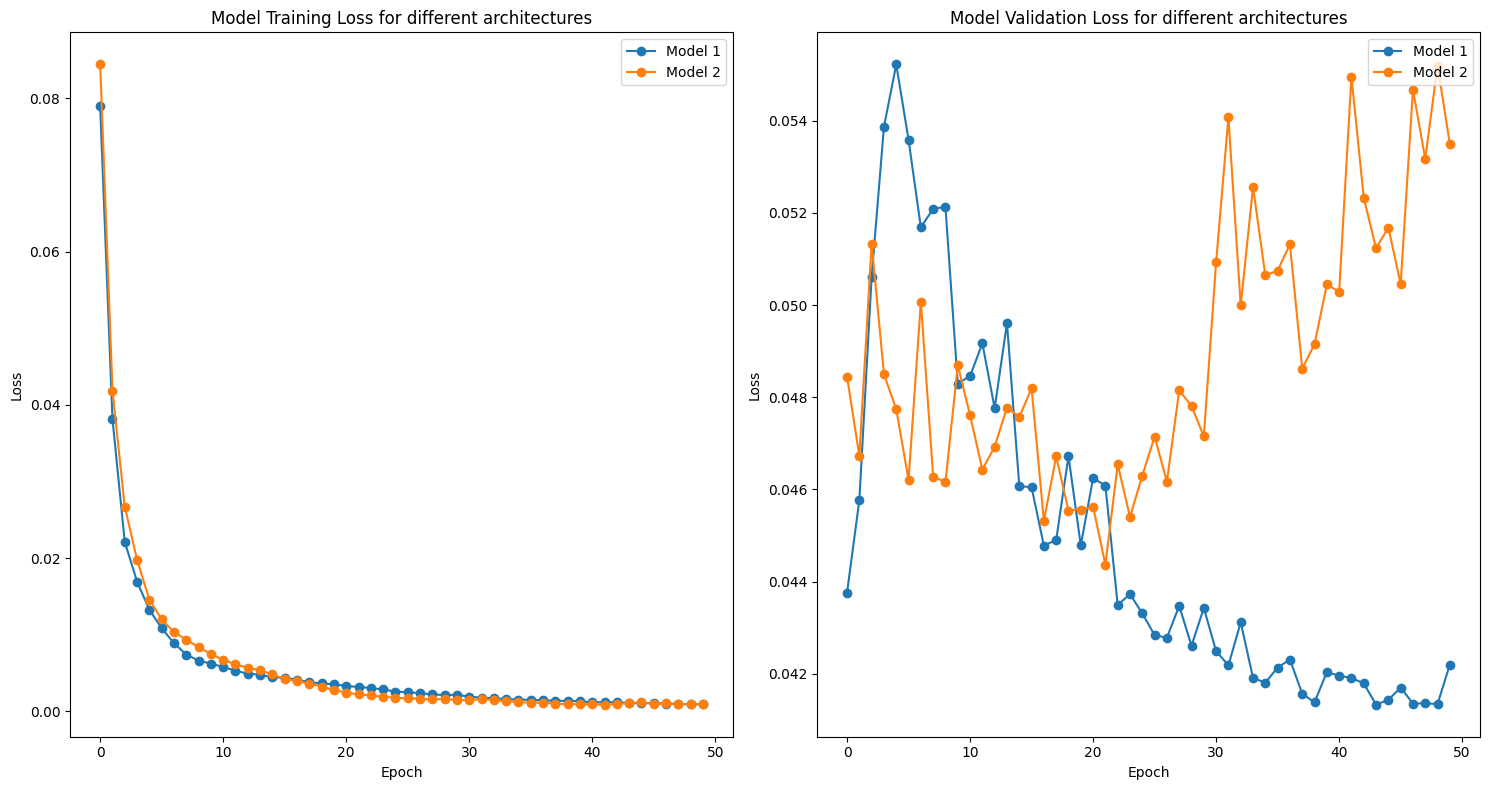

Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size


In [38]:
# visualise training and validation loss for all models
plt.figure(figsize=(15, 8))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o')
plt.plot(history2.history['loss'], label='Model 2', marker='o')
plt.title('Model Training Loss for different architectures')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o')
plt.title('Model Validation Loss for different architectures')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training_amz.png")
plt.show()

# print models
print("Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")

### Evaluating NCF Model

In [41]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = model.predict([test_x['user'], test_x['product']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Binarise the hidden ratings and predicted ratings
threshold = 3.5
binary_prediction_ratings = (predicted_ratings_array >= threshold).astype(int) 
binary_hidden_ratings = (hidden_ratings_array >= threshold).astype(int)

# Classification predictions
accuracy = accuracy_score(binary_hidden_ratings, binary_prediction_ratings)
precision = precision_score(binary_hidden_ratings, binary_prediction_ratings)
recall = recall_score(binary_hidden_ratings, binary_prediction_ratings)
f1 = f1_score(binary_hidden_ratings, binary_prediction_ratings)
print("\nClassification Metrics")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

26/26 [==============================] - 0s 7ms/step

Rating Metrics
Mean Absolute Error (MAE): 0.8416438227579778
Mean Squared Error (MSE): 1.4333605219902348
Root Mean Squared Error (RMSE): 1.1972303546060945

Classification Metrics
Accuracy: 0.7680798004987531
Precision: 0.8621700879765396
Recall: 0.8647058823529412
F1 Score: 0.8634361233480177


## Model 2: Ratings + Reviews

## Model 3: Ratings + Reviews + Sentiments 

## Benchmarking Recommender Model

We want to build a **naive benchmark model to compare with our NCF model**. The benchmark model will predict the rating of a user-item pair as:

1. the most popular rating in the training set. For example, if the most popular rating in the training set is 4, then the benchmark model will predict the rating of all user-item pairs as 4.

***TLDR***: The benchmark model, which predicts a constant value (5) for all ratings, outperforms the NCF model in terms of rating metrics and some classification metrics. The NCF model, while providing reasonable results, might need further optimization or tuning to improve its performance, especially in terms of rating prediction.


In [55]:
# Benchmark Model 1 (make it all 5s) ====================================
benchmark_results_1 = predicted_ratings_array.copy()
benchmark_results_1.fill(5)

In [52]:
# evaluate benchmark model 1 ====================================
predicted_ratings_array = benchmark_results_1

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Binarise the hidden ratings and predicted ratings
threshold = 3.5
binary_prediction_ratings = (predicted_ratings_array >= threshold).astype(int) 
binary_hidden_ratings = (hidden_ratings_array >= threshold).astype(int)

# Classification predictions
accuracy = accuracy_score(binary_hidden_ratings, binary_prediction_ratings)
precision = precision_score(binary_hidden_ratings, binary_prediction_ratings)
recall = recall_score(binary_hidden_ratings, binary_prediction_ratings)
f1 = f1_score(binary_hidden_ratings, binary_prediction_ratings)
print("\nClassification Metrics")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Rating Metrics
Mean Absolute Error (MAE): 0.64214463840399
Mean Squared Error (MSE): 1.3054862842892767
Root Mean Squared Error (RMSE): 1.1425787869067396

Classification Metrics
Accuracy: 0.8478802992518704
Precision: 0.8478802992518704
Recall: 1.0
F1 Score: 0.9176788124156545


***
# Example

This is a basic implementation of the NCF model. For more advanced features (like adding more layers to the model or using different activation functions), you might need to modify the code accordingly. Also, remember to handle overfitting and underfitting by tuning your model and using techniques like early stopping, regularization, etc.

The code below will train a NCF model on your data and then use it to predict the ratings. The predicted ratings will be stored in the y_pred variable. You can adjust the parameters of the model (such as the number of epochs, the batch size, and the dimensions of the embedding layers) to better fit your data



In [379]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

# tensorflow libraries
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [380]:
# get original data
data = pd.read_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data.csv", index_col=0)
print("Original Data:")
display(data)

# create a copy of the original matrix to store hidden ratings
data_hidden = data.copy()

# identifies rated books and randomly selects 2 books to hide ratings for each user
np.random.seed(10)  # You can use any integer value as the seed
for user_id in range(data_hidden.shape[0]):
    rated_books = np.where(data_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_books, min(2, len(rated_books)), replace=False)
    data_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = data_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'book', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index
print("Indices of Hidden Ratings:", indices_hidden)

# check hidden data
print("\n\nHidden Data:")
display(data_hidden)

Original Data:


,book1,book2,book3,book4,book5,book6,book7,book8,book9,book10
user1,0,0,2,5,4,3,4,4,4,4
user2,4,0,3,5,0,0,0,0,0,4
user3,0,3,4,4,0,2,0,0,0,0
user4,0,0,3,5,4,0,0,0,0,0
user5,3,4,0,4,4,0,5,5,5,5
user6,4,5,0,0,0,0,4,2,2,0
user7,2,2,0,0,0,0,5,3,3,3
user8,0,5,4,0,4,3,0,0,0,0
user9,0,5,4,0,5,2,0,2,2,0
user10,0,0,0,0,5,0,4,4,4,4


Indices of Hidden Ratings: Index([ 10,  14,  16,  17,  19,  20,  23,  27,  34,  37,  48,  51,  57,  60,
        62,  67,  81,  92,  95, 101, 102, 109, 112, 114],
      dtype='int64')


Hidden Data:


,book1,book2,book3,book4,book5,book6,book7,book8,book9,book10
user1,0,0,2,5,Hidden,Hidden,4,4,4,4
user2,4,0,3,Hidden,0,0,0,0,0,Hidden
user3,0,Hidden,4,4,0,Hidden,0,0,0,0
user4,0,0,Hidden,5,Hidden,0,0,0,0,0
user5,3,Hidden,0,4,4,0,5,5,5,Hidden
user6,4,Hidden,0,0,0,0,4,2,Hidden,0
user7,2,2,0,0,0,0,5,3,Hidden,Hidden
user8,0,Hidden,4,0,4,Hidden,0,0,0,0
user9,0,Hidden,4,0,5,2,0,Hidden,2,0
user10,0,0,0,0,Hidden,0,Hidden,4,4,4


In [381]:
# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = data_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='book', value_name='rating')

# change rows with hidden ratings to 0
data_hidden.iloc[indices_hidden, 2] = 0

print("Melted Data:")
display(data_hidden)
data_hidden.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data_hidden.csv")

Melted Data:


,index,book,rating
0,user1,book1,0
1,user2,book1,4
2,user3,book1,0
3,user4,book1,0
4,user5,book1,3
...,...,...,...
115,user8,book10,0
116,user9,book10,0
117,user10,book10,4
118,user11,book10,0


In [382]:
# rename columns
data_hidden.columns = ['user', 'book', 'rating']

# Filter out the rows where rating is 0
data_hidden = data_hidden[data_hidden['rating'] != 0]
print("Training Data with Hidden Ratings and Non-Zero Ratings:")
display(data_hidden)
data_hidden.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data_hidden_zeros.csv")

# Convert user and book to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['book'] = data_hidden['book'].astype('category')

Training Data with Hidden Ratings and Non-Zero Ratings:


,user,book,rating
1,user2,book1,4
4,user5,book1,3
5,user6,book1,4
6,user7,book1,2
11,user12,book1,5
18,user7,book2,2
22,user11,book2,2
24,user1,book3,2
25,user2,book3,3
26,user3,book3,4


In [383]:
# Create user and book embedding layers
user_input = Input(shape=(1,), dtype='int32', name='user_input')
book_input = Input(shape=(1,), dtype='int32', name='book_input')

user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
book_embedding = Embedding(input_dim=len(data_hidden['book'].cat.categories), output_dim=50, name='book_embedding')(book_input)

# Flatten the embedding vectors
user_vecs = Flatten()(user_embedding)
book_vecs = Flatten()(book_embedding)

# Concatenate the embedding vectors
input_vecs = Concatenate()([user_vecs, book_vecs])

# Add dense layers
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
y = Dense(1)(x)

# Compile the model
model = Model(inputs=[user_input, book_input], outputs=y)
model.compile(optimizer=Adam(0.001), loss='mse')

# Prepare the data - trining
X = data_hidden[['user', 'book']].apply(lambda x: x.cat.codes)
y = data_hidden['rating'].astype(np.float64)
y = (y - 1) / 4

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='book', value_name='rating')
copy.columns = ['user', 'book', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['book'] = test_x['book'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4



In [384]:
# see training X and y
print("Training X:")
display(X)

print("Training y:")
display(y)

# save
X.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_X.csv")
y.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_y.csv")

Training X:


,user,book
1,4,0
4,7,0
5,8,0
6,9,0
11,3,0
18,9,2
22,2,2
24,0,3
25,4,3
26,5,3


Training y:


1      0.75
4      0.50
5      0.75
6      0.25
11     1.00
18     0.25
22     0.25
24     0.25
25     0.50
26     0.75
31     0.75
32     0.75
35     0.50
36     1.00
38     0.75
39     1.00
40     0.75
52     0.75
55     0.75
56     1.00
58     1.00
59     0.25
68     0.25
71     0.50
72     0.75
76     1.00
77     0.75
78     1.00
82     1.00
83     0.50
84     0.75
88     1.00
89     0.25
90     0.50
93     0.75
94     1.00
96     0.75
100    1.00
104    0.25
105    0.75
106    1.00
107    0.50
108    0.75
117    0.75
Name: rating, dtype: float64

In [385]:
# see training X and y
print("Testing X:")
display(test_x)

print("Testing y:")
display(test_y)

# save
test_x.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_test_X.csv")
test_y.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_test_Y.csv")

Testing X:


,user,book
10,2,0
14,5,2
16,7,2
17,8,2
19,10,2
20,11,2
23,3,2
27,6,3
34,2,3
37,4,4


Testing y:


10     0.75
14     0.50
16     0.75
17     1.00
19     1.00
20     1.00
23     1.00
27     0.50
34     0.25
37     1.00
48     0.75
51     0.75
57     1.00
60     0.50
62     0.25
67     0.50
81     0.75
92     0.25
95     0.50
101    0.25
102    0.50
109    0.75
112    1.00
114    0.50
Name: rating, dtype: float64

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.5635 - val_loss: 0.5655
Epoch 2/50
1/1 [==============================] - 0s 58ms/step - loss: 0.5340 - val_loss: 0.5412
Epoch 3/50
1/1 [==============================] - 0s 43ms/step - loss: 0.5073 - val_loss: 0.5193
Epoch 4/50
1/1 [==============================] - 0s 45ms/step - loss: 0.4846 - val_loss: 0.4973
Epoch 5/50
1/1 [==============================] - 0s 54ms/step - loss: 0.4566 - val_loss: 0.4757
Epoch 6/50
1/1 [==============================] - 0s 53ms/step - loss: 0.4403 - val_loss: 0.4543
Epoch 7/50
1/1 [==============================] - 0s 47ms/step - loss: 0.4254 - val_loss: 0.4319
Epoch 8/50
1/1 [==============================] - 0s 50ms/step - loss: 0.3936 - val_loss: 0.4089
Epoch 9/50
1/1 [==============================] - 0s 50ms/step - loss: 0.3797 - val_loss: 0.3854
Epoch 10/50
1/1 [==============================] - 0s 70ms/step - loss: 0.3592 - val_loss: 0.3613
Epoch 11/50
1/1 [==============

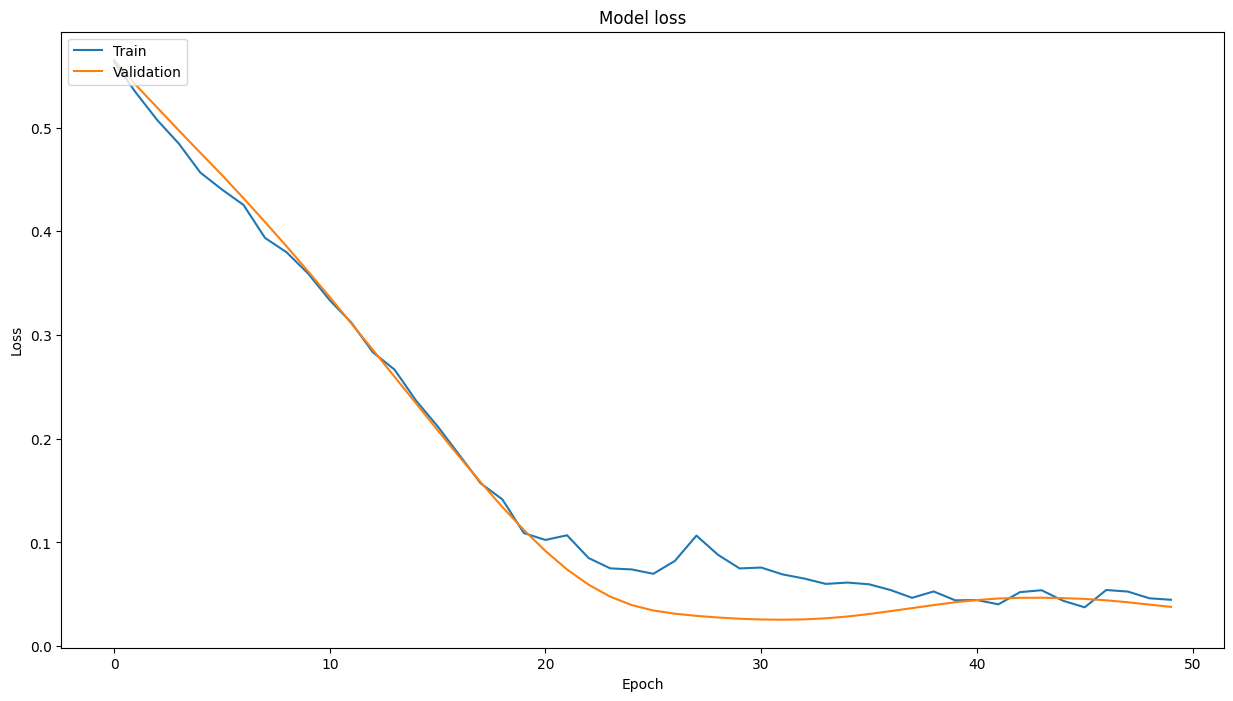

In [386]:
# Train the model
history = model.fit([X['user'], X['book']], y, batch_size=64, epochs=50, validation_split=0.1)

# Plot training & validation loss values
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [387]:
# Predict the ratings
y_pred = model.predict([test_x['user'], test_x['book']])

# Rescale the predictions back to the 1 - 5 range
y_pred = y_pred * 4 + 1

# see predictions
print("Predictions:")
display(y_pred)

# save
pd.DataFrame(y_pred).to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_y_pred.csv")

1/1 [==============================] - 0s 167ms/step
Predictions:


array([[4.1393805],
       [2.4230828],
       [2.4972453],
       [1.6612036],
       [2.4073176],
       [2.1226764],
       [1.9409723],
       [3.242445 ],
       [3.7316537],
       [4.0426974],
       [3.5080423],
       [3.9258206],
       [3.6982021],
       [2.6096811],
       [2.9007297],
       [2.9094064],
       [4.2280955],
       [3.4573026],
       [3.1991434],
       [2.9439116],
       [3.015808 ],
       [2.9595542],
       [3.5647516],
       [2.6196575]], dtype=float32)

In [389]:
# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# see
print("Hidden Ratings:")
display(hidden_ratings_array)

print("Predicted Ratings:")
display(predicted_ratings_array)

Hidden Ratings:


array([4., 3., 4., 5., 5., 5., 5., 3., 2., 5., 4., 4., 5., 3., 2., 3., 4.,
       2., 3., 2., 3., 4., 5., 3.])

Predicted Ratings:


array([4.1393805, 2.4230828, 2.4972453, 1.6612036, 2.4073176, 2.1226764,
       1.9409723, 3.242445 , 3.7316537, 4.0426974, 3.5080423, 3.9258206,
       3.6982021, 2.6096811, 2.9007297, 2.9094064, 4.2280955, 3.4573026,
       3.1991434, 2.9439116, 3.015808 , 2.9595542, 3.5647516, 2.6196575],
      dtype=float32)

In [390]:
# calculate MAE, MSE and RMSE (take the hidden ratings as the true values and the predicted ratings as the predicted values) ==========================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate MAE, MSE and RMSE
print("Using sklearn")
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Manually
print("\n\nManually")
mae = np.mean(np.abs(hidden_ratings_array - predicted_ratings_array)) # Calculate Mean Absolute Error (MAE)
mse = np.mean((hidden_ratings_array - predicted_ratings_array) ** 2) # Calculate Mean Squared Error (MSE)
rmse = np.sqrt(mse) # Calculate Root Mean Squared Error (RMSE)


print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Using sklearn
Mean Absolute Error (MAE): 1.0820066034793854
Mean Squared Error (MSE): 2.141600107994963
Root Mean Squared Error (RMSE): 1.4634206872922644


Manually
Mean Absolute Error (MAE): 1.0820066034793854
Mean Squared Error (MSE): 2.141600107994963
Root Mean Squared Error (RMSE): 1.4634206872922644


In [391]:
# step 4: calculate Classification Metrics (take the hidden ratings and the predicted ratings and binarise them) ==========================================================================

# Binarise the hidden ratings and predicted ratings
threshold = 3.5
binary_prediction_ratings = (predicted_ratings_array >= threshold).astype(int) 
print(f"If predicted rating is greater than or equal to {threshold}, then 1, else 0\n")
print("Predicted Ratings:", predicted_ratings_array)
print("Binary Predictions:", binary_prediction_ratings)
binary_hidden_ratings = (hidden_ratings_array >= threshold).astype(int)
print("\n")

print("Hidden Ratings:", hidden_ratings_array)
print("Binary Hidden Ratings:", binary_hidden_ratings)

If predicted rating is greater than or equal to 3.5, then 1, else 0

Predicted Ratings: [4.1393805 2.4230828 2.4972453 1.6612036 2.4073176 2.1226764 1.9409723
 3.242445  3.7316537 4.0426974 3.5080423 3.9258206 3.6982021 2.6096811
 2.9007297 2.9094064 4.2280955 3.4573026 3.1991434 2.9439116 3.015808
 2.9595542 3.5647516 2.6196575]
Binary Predictions: [1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0]


Hidden Ratings: [4. 3. 4. 5. 5. 5. 5. 3. 2. 5. 4. 4. 5. 3. 2. 3. 4. 2. 3. 2. 3. 4. 5. 3.]
Binary Hidden Ratings: [1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0]


In [392]:
# calculate accuracy using sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# calculate accuracy using sklearn
print("Using sklearn")
accuracy = accuracy_score(binary_hidden_ratings, binary_prediction_ratings)
precision = precision_score(binary_hidden_ratings, binary_prediction_ratings)
recall = recall_score(binary_hidden_ratings, binary_prediction_ratings)
f1 = f1_score(binary_hidden_ratings, binary_prediction_ratings)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# calculate accuracy manually
print("\n\nManually")
true_positives = np.sum((binary_hidden_ratings == 1) & (binary_prediction_ratings == 1))
true_negatives = np.sum((binary_hidden_ratings == 0) & (binary_prediction_ratings == 0))
false_positives = np.sum((binary_hidden_ratings == 0) & (binary_prediction_ratings == 1))
false_negatives = np.sum((binary_hidden_ratings == 1) & (binary_prediction_ratings == 0))

accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Using sklearn
Accuracy: 0.7083333333333334
Precision: 0.875
Recall: 0.5384615384615384
F1 Score: 0.6666666666666667


Manually
Accuracy: 0.7083333333333334
Precision: 0.875
Recall: 0.5384615384615384
F1 Score: 0.6666666666666667


### Hyperparameter Tuning

Experimenting with different parameters and visualizing the training process can provide valuable insights into how well our model is performing and where improvements can be made.

- ***Plot Training and Validation Loss:*** This can help you understand if your model is overfitting or underfitting. If your training loss is much lower than your validation loss, your model might be overfitting. If both losses are high, your model might be underfitting.

- ***Experiment with Different Architectures:*** Try adding more layers to your model or increasing the number of neurons in each layer. You could also experiment with different types of layers (e.g., convolutional layers, recurrent layers) and different activation functions.

- ***Tune Hyperparameters***: This includes the learning rate, batch size, number of epochs, and regularization parameters. You could use techniques like grid search or random search to systematically explore different combinations of hyperparameters.

- ***Use Early Stopping:*** This technique allows you to stop training once the model’s performance on a validation set stops improving, which can be useful to prevent overfitting.

- ***Try Different Optimization Algorithms:*** In addition to Adam, there are many other optimization algorithms available in TensorFlow, such as SGD, RMSprop, and Adagrad. Different optimizers might lead to different results.

- ***Regularization:*** If your model is overfitting, you might want to add some form of regularization, such as L1 or L2 regularization, or dropout.

- ***Data Augmentation***: If you have a small dataset, you could artificially increase its size by creating modified versions of your existing data. For example, you could add small amounts of noise to your input data.

- ***Learning Rate Scheduling:*** Instead of using a fixed learning rate, you could decrease it over time or in response to the model’s performance.


In [423]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# tensorflow libraries
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [424]:
# DATA LOADING ====================================

# get original data
data = pd.read_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data.csv", index_col=0)

# create a copy of the original matrix to store hidden ratings
data_hidden = data.copy()

# identifies rated books and randomly selects 2 books to hide ratings for each user
np.random.seed(10)  # You can use any integer value as the seed
for user_id in range(data_hidden.shape[0]):
    rated_books = np.where(data_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_books, min(2, len(rated_books)), replace=False)
    data_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = data_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'book', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = data_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='book', value_name='rating')

# change rows with hidden ratings to 0
data_hidden.iloc[indices_hidden, 2] = 0

# rename columns
data_hidden.columns = ['user', 'book', 'rating']

# Filter out the rows where rating is 0
data_hidden = data_hidden[data_hidden['rating'] != 0]

# Convert user and book to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['book'] = data_hidden['book'].astype('category')


In [425]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'book']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='book', value_name='rating')
copy.columns = ['user', 'book', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['book'] = test_x['book'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

In [429]:
# Function to train a neural network model for collaborative filtering
def train_model(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y, seed=10, train_plot=True):
    """
    Function to train a neural network model for collaborative filtering.
    :param n_layers: Number of dense layers in the model
    :param n_nodes: Number of nodes in each dense layer
    :param optimizer: Optimizer to use for training
    :param epochs: Number of epochs to train for
    :param learning_rate: Learning rate for the optimizer
    :param train_x: Training data
    :param train_y: Training labels
    :param seed: Random seed
    :return: Trained model and training history
    """
    # Set random seed
    np.random.seed(seed)

    # Create user and book embedding layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    book_input = Input(shape=(1,), dtype='int32', name='book_input')

    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    book_embedding = Embedding(input_dim=len(data_hidden['book'].cat.categories), output_dim=50, name='book_embedding')(book_input)

    # Flatten the embedding vectors
    user_vecs = Flatten()(user_embedding)
    book_vecs = Flatten()(book_embedding)

    # Concatenate the embedding vectors
    input_vecs = Concatenate()([user_vecs, book_vecs])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
    y = Dense(1)(x)

    # Compile the model
    model = Model(inputs=[user_input, book_input], outputs=y)
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Train the model
    history = model.fit([train_x['user'], train_x['book']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training.png")
        plt.show()
    
    return model, history

In [456]:
# Train the model
model, history = train_model(n_layers=2, n_nodes=256, optimizer='adam', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 2 - 3 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size
model2, history2 = train_model(n_layers=3, n_nodes=256, optimizer='adam', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 3 - 2 layers, 256 nodes, sgd, 100 epochs, 0.001 learning rate, 64 batch size
model3, history3 = train_model(n_layers=2, n_nodes=256, optimizer='sgd', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 4 - 3 layers, 256 nodes, sgd, 100 epochs, 0.001 learning rate, 64 batch size
model4, history4 = train_model(n_layers=3, n_nodes=256, optimizer='sgd', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 5 - 2 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size
model5, history5 = train_model(n_layers=2, n_nodes=256, optimizer='rmsprop', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 6 - 3 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size
model6, history6 = train_model(n_layers=3, n_nodes=256, optimizer='rmsprop', epochs=100, learning_rate=0.001, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 7 - 2 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size
model7, history7 = train_model(n_layers=2, n_nodes=256, optimizer='adam', epochs=100, learning_rate=0.01, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)

# Model 8 - 3 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size
model8, history8 = train_model(n_layers=3, n_nodes=256, optimizer='adam', epochs=100, learning_rate=0.01, batch_size=64, train_x=train_x, train_y=train_y, seed=10, train_plot=False)


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.5390 - val_loss: 0.5478
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.4867 - val_loss: 0.4995
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.4444 - val_loss: 0.4531
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 0.4011 - val_loss: 0.4081
Epoch 5/100
1/1 [==============================] - 0s 47ms/step - loss: 0.3565 - val_loss: 0.3636
Epoch 6/100
1/1 [==============================] - 0s 51ms/step - loss: 0.3172 - val_loss: 0.3195
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 0.2746 - val_loss: 0.2763
Epoch 8/100
1/1 [==============================] - 0s 49ms/step - loss: 0.2299 - val_loss: 0.2332
Epoch 9/100
1/1 [==============================] - 0s 47ms/step - loss: 0.1803 - val_loss: 0.1912
Epoch 10/100
1/1 [==============================] - 0s 49ms/step - loss: 0.1490 - val_loss: 0.1517
Epoch 11/100
1/1 [===

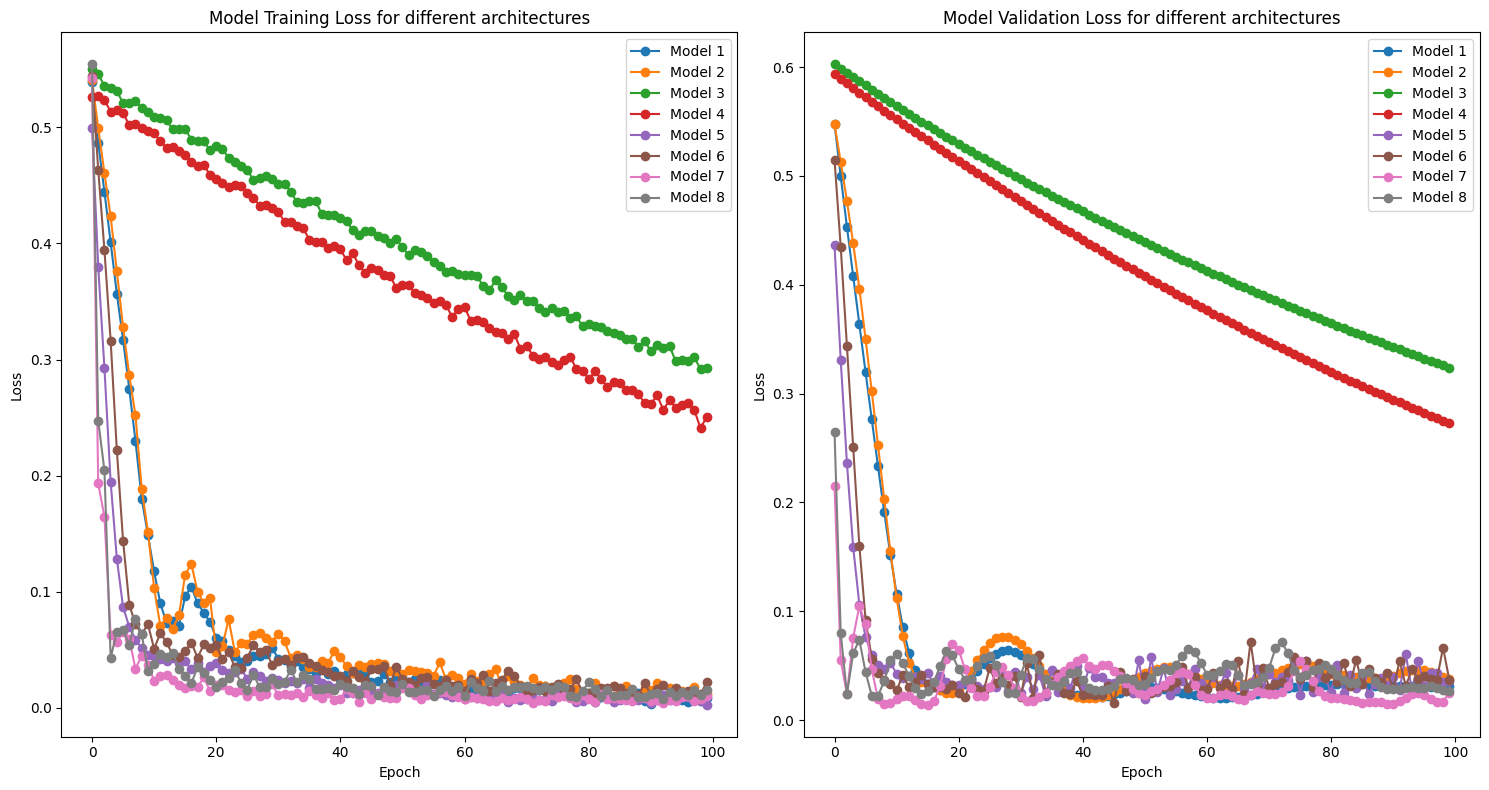

Model 1: 2 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size
Model 3: 2 layers, 256 nodes, sgd, 100 epochs, 0.01 learning rate, 64 batch size
Model 4: 3 layers, 256 nodes, sgd, 100 epochs, 0.01 learning rate, 64 batch size
Model 5: 2 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size
Model 6: 3 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size
Model 7: 2 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size
Model 8: 3 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size


In [457]:
# visualise training and validation loss for all models
plt.figure(figsize=(15, 8))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o')
plt.plot(history2.history['loss'], label='Model 2', marker='o')
plt.plot(history3.history['loss'], label='Model 3', marker='o')
plt.plot(history4.history['loss'], label='Model 4', marker='o')
plt.plot(history5.history['loss'], label='Model 5', marker='o')
plt.plot(history6.history['loss'], label='Model 6', marker='o')
plt.plot(history7.history['loss'], label='Model 7', marker='o')
plt.plot(history8.history['loss'], label='Model 8', marker='o')
plt.title('Model Training Loss for different architectures')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o')
plt.plot(history5.history['val_loss'], label='Model 5', marker='o')
plt.plot(history6.history['val_loss'], label='Model 6', marker='o')
plt.plot(history7.history['val_loss'], label='Model 7', marker='o')
plt.plot(history8.history['val_loss'], label='Model 8', marker='o')
plt.title('Model Validation Loss for different architectures')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\ncf_training_all.png")
plt.show()

# print models
print("Model 1: 2 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 256 nodes, adam, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 3: 2 layers, 256 nodes, sgd, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 4: 3 layers, 256 nodes, sgd, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 5: 2 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 6: 3 layers, 256 nodes, rmsprop, 100 epochs, 0.001 learning rate, 64 batch size")
print("Model 7: 2 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size")
print("Model 8: 3 layers, 256 nodes, adam, 100 epochs, 0.01 learning rate, 64 batch size")


In [ ]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = model.predict([test_x['user'], test_x['book']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Binarise the hidden ratings and predicted ratings
threshold = 3.5
binary_prediction_ratings = (predicted_ratings_array >= threshold).astype(int) 
binary_hidden_ratings = (hidden_ratings_array >= threshold).astype(int)

# Classification predictions
accuracy = accuracy_score(binary_hidden_ratings, binary_prediction_ratings)
precision = precision_score(binary_hidden_ratings, binary_prediction_ratings)
recall = recall_score(binary_hidden_ratings, binary_prediction_ratings)
f1 = f1_score(binary_hidden_ratings, binary_prediction_ratings)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")